In [62]:
# 加载数据
import torch
from joblib import dump, load
import torch.utils.data as Data
import numpy as np
import pandas as pd
import torch.nn as nn
from torch.nn import Transformer, TransformerEncoder, TransformerEncoderLayer

# 参数与配置
torch.manual_seed(100)  # 设置随机种子，以使实验结果具有可重复性
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")



# 数据集 超参数设置
BATCH_SIZE = 16   #  16 32 64
NUM_WORKERS = 0   # 0  2

# 加载数据集

# 训练集
train_set = load('./dataresult/train_X')
train_label = load('./dataresult/train_y')
# 测试集
test_set = load('./dataresult/test_X')
test_label = load('./dataresult/test_y')

# 加载数据
train_loader = Data.DataLoader(
    dataset=Data.TensorDataset(train_set, train_label),
    batch_size=BATCH_SIZE,
    shuffle=False,
    drop_last=False, 
    num_workers=NUM_WORKERS
)

test_loader = Data.DataLoader(
    dataset=Data.TensorDataset(test_set, test_label),             
    batch_size=BATCH_SIZE,
    shuffle=False,
    drop_last=False, 
    num_workers=NUM_WORKERS
)


print(len(train_loader))
print(len(test_loader))

17
10


### 定义 KANLinear

In [63]:
import torch
import torch.nn.functional as F
import math

class KANLinear(torch.nn.Module):
    def __init__(
        self,
        in_features,
        out_features,
        grid_size=5,  # 网格大小，默认为 5
        spline_order=3, # 分段多项式的阶数，默认为 3
        scale_noise=0.1,  # 缩放噪声，默认为 0.1
        scale_base=1.0,   # 基础缩放，默认为 1.0
        scale_spline=1.0,    # 分段多项式的缩放，默认为 1.0
        enable_standalone_scale_spline=True,
        base_activation=torch.nn.SiLU,  # 基础激活函数，默认为 SiLU（Sigmoid Linear Unit）
        grid_eps=0.02,
        grid_range=[-1, 1],  # 网格范围，默认为 [-1, 1]
    ):
        super(KANLinear, self).__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.grid_size = grid_size # 设置网格大小和分段多项式的阶数
        self.spline_order = spline_order

        h = (grid_range[1] - grid_range[0]) / grid_size   # 计算网格步长
        grid = ( # 生成网格
            (
                torch.arange(-spline_order, grid_size + spline_order + 1) * h
                + grid_range[0] 
            )
            .expand(in_features, -1)
            .contiguous()
        )
        self.register_buffer("grid", grid)  # 将网格作为缓冲区注册

        self.base_weight = torch.nn.Parameter(torch.Tensor(out_features, in_features)) # 初始化基础权重和分段多项式权重
        self.spline_weight = torch.nn.Parameter(
            torch.Tensor(out_features, in_features, grid_size + spline_order)
        )
        if enable_standalone_scale_spline:  # 如果启用独立的分段多项式缩放，则初始化分段多项式缩放参数
            self.spline_scaler = torch.nn.Parameter(
                torch.Tensor(out_features, in_features)
            )

        self.scale_noise = scale_noise # 保存缩放噪声、基础缩放、分段多项式的缩放、是否启用独立的分段多项式缩放、基础激活函数和网格范围的容差
        self.scale_base = scale_base
        self.scale_spline = scale_spline
        self.enable_standalone_scale_spline = enable_standalone_scale_spline
        self.base_activation = base_activation()
        self.grid_eps = grid_eps

        self.reset_parameters()  # 重置参数

    def reset_parameters(self):
        torch.nn.init.kaiming_uniform_(self.base_weight, a=math.sqrt(5) * self.scale_base)# 使用 Kaiming 均匀初始化基础权重
        with torch.no_grad():
            noise = (# 生成缩放噪声
                (
                    torch.rand(self.grid_size + 1, self.in_features, self.out_features)
                    - 1 / 2
                )
                * self.scale_noise
                / self.grid_size
            )
            self.spline_weight.data.copy_( # 计算分段多项式权重
                (self.scale_spline if not self.enable_standalone_scale_spline else 1.0)
                * self.curve2coeff(
                    self.grid.T[self.spline_order : -self.spline_order],
                    noise,
                )
            )
            if self.enable_standalone_scale_spline:  # 如果启用独立的分段多项式缩放，则使用 Kaiming 均匀初始化分段多项式缩放参数
                # torch.nn.init.constant_(self.spline_scaler, self.scale_spline)
                torch.nn.init.kaiming_uniform_(self.spline_scaler, a=math.sqrt(5) * self.scale_spline)

    def b_splines(self, x: torch.Tensor):
        """
        Compute the B-spline bases for the given input tensor.

        Args:
            x (torch.Tensor): Input tensor of shape (batch_size, in_features).

        Returns:
            torch.Tensor: B-spline bases tensor of shape (batch_size, in_features, grid_size + spline_order).
        """
        """
        计算给定输入张量的 B-样条基函数。

        参数:
        x (torch.Tensor): 输入张量，形状为 (batch_size, in_features)。

        返回:
        torch.Tensor: B-样条基函数张量，形状为 (batch_size, in_features, grid_size + spline_order)。
        """
        assert x.dim() == 2 and x.size(1) == self.in_features

        grid: torch.Tensor = ( # 形状为 (in_features, grid_size + 2 * spline_order + 1)
            self.grid
        )  # (in_features, grid_size + 2 * spline_order + 1)
        x = x.unsqueeze(-1)
        bases = ((x >= grid[:, :-1]) & (x < grid[:, 1:])).to(x.dtype)
        for k in range(1, self.spline_order + 1):
            bases = (
                (x - grid[:, : -(k + 1)])
                / (grid[:, k:-1] - grid[:, : -(k + 1)])
                * bases[:, :, :-1]
            ) + (
                (grid[:, k + 1 :] - x)
                / (grid[:, k + 1 :] - grid[:, 1:(-k)])
                * bases[:, :, 1:]
            )

        assert bases.size() == (
            x.size(0),
            self.in_features,
            self.grid_size + self.spline_order,
        )
        return bases.contiguous()

    def curve2coeff(self, x: torch.Tensor, y: torch.Tensor):
        """
        Compute the coefficients of the curve that interpolates the given points.

        Args:
            x (torch.Tensor): Input tensor of shape (batch_size, in_features).
            y (torch.Tensor): Output tensor of shape (batch_size, in_features, out_features).

        Returns:
            torch.Tensor: Coefficients tensor of shape (out_features, in_features, grid_size + spline_order).
        """
        """
        计算插值给定点的曲线的系数。

        参数:
        x (torch.Tensor): 输入张量，形状为 (batch_size, in_features)。
        y (torch.Tensor): 输出张量，形状为 (batch_size, in_features, out_features)。
        返回:
        torch.Tensor: 系数张量，形状为 (out_features, in_features, grid_size + spline_order)。
        """
        assert x.dim() == 2 and x.size(1) == self.in_features
        assert y.size() == (x.size(0), self.in_features, self.out_features)
        # 计算 B-样条基函数
        A = self.b_splines(x).transpose(
            0, 1 # 形状为 (in_features, batch_size, grid_size + spline_order)
        )  # (in_features, batch_size, grid_size + spline_order)
        B = y.transpose(0, 1)  # (in_features, batch_size, out_features) # 形状为 (in_features, batch_size, out_features)
        solution = torch.linalg.lstsq(   # 使用最小二乘法求解线性方程组
            A, B
        ).solution  # (in_features, grid_size + spline_order, out_features)  # 形状为 (in_features, grid_size + spline_order, out_features)
        result = solution.permute( # 调整结果的维度顺序
            2, 0, 1
        )  # (out_features, in_features, grid_size + spline_order)

        assert result.size() == (
            self.out_features,
            self.in_features,
            self.grid_size + self.spline_order,
        )
        return result.contiguous()

    @property
    def scaled_spline_weight(self):
        """
        获取缩放后的分段多项式权重。

        返回:
        torch.Tensor: 缩放后的分段多项式权重张量，形状与 self.spline_weight 相同。
        """
        return self.spline_weight * (
            self.spline_scaler.unsqueeze(-1)
            if self.enable_standalone_scale_spline
            else 1.0
        )

    def forward(self, x: torch.Tensor): # 将输入数据通过模型的各个层，经过线性变换和激活函数处理，最终得到模型的输出结果
        """
        前向传播函数。

        参数:
        x (torch.Tensor): 输入张量，形状为 (batch_size, in_features)。

        返回:
        torch.Tensor: 输出张量，形状为 (batch_size, out_features)。
        """
        assert x.dim() == 2 and x.size(1) == self.in_features

        base_output = F.linear(self.base_activation(x), self.base_weight) # 计算基础线性层的输出
        spline_output = F.linear( # 计算分段多项式线性层的输出
            self.b_splines(x).view(x.size(0), -1),
            self.scaled_spline_weight.view(self.out_features, -1),
        )
        return base_output + spline_output  # 返回基础线性层输出和分段多项式线性层输出的和

    @torch.no_grad()
    # 更新网格。
    # 参数:
    # x (torch.Tensor): 输入张量，形状为 (batch_size, in_features)。
    # margin (float): 网格边缘空白的大小。默认为 0.01。
    # 根据输入数据 x 的分布情况来动态更新模型的网格,使得模型能够更好地适应输入数据的分布特点，从而提高模型的表达能力和泛化能力。
    def update_grid(self, x: torch.Tensor, margin=0.01): 
        assert x.dim() == 2 and x.size(1) == self.in_features
        batch = x.size(0)

        splines = self.b_splines(x)  # (batch, in, coeff)  # 计算 B-样条基函数
        splines = splines.permute(1, 0, 2)  # (in, batch, coeff)  # 调整维度顺序为 (in, batch, coeff)
        orig_coeff = self.scaled_spline_weight  # (out, in, coeff)
        orig_coeff = orig_coeff.permute(1, 2, 0)  # (in, coeff, out)  # 调整维度顺序为 (in, coeff, out)
        unreduced_spline_output = torch.bmm(splines, orig_coeff)  # (in, batch, out)
        unreduced_spline_output = unreduced_spline_output.permute(
            1, 0, 2
        )  # (batch, in, out)

        # sort each channel individually to collect data distribution
        x_sorted = torch.sort(x, dim=0)[0] # 对每个通道单独排序以收集数据分布
        grid_adaptive = x_sorted[
            torch.linspace(
                0, batch - 1, self.grid_size + 1, dtype=torch.int64, device=x.device
            )
        ]

        uniform_step = (x_sorted[-1] - x_sorted[0] + 2 * margin) / self.grid_size
        grid_uniform = (
            torch.arange(
                self.grid_size + 1, dtype=torch.float32, device=x.device
            ).unsqueeze(1)
            * uniform_step
            + x_sorted[0]
            - margin
        )

        grid = self.grid_eps * grid_uniform + (1 - self.grid_eps) * grid_adaptive
        grid = torch.concatenate(
            [
                grid[:1]
                - uniform_step
                * torch.arange(self.spline_order, 0, -1, device=x.device).unsqueeze(1),
                grid,
                grid[-1:]
                + uniform_step
                * torch.arange(1, self.spline_order + 1, device=x.device).unsqueeze(1),
            ],
            dim=0,
        )

        self.grid.copy_(grid.T)   # 更新网格和分段多项式权重
        self.spline_weight.data.copy_(self.curve2coeff(x, unreduced_spline_output))

    def regularization_loss(self, regularize_activation=1.0, regularize_entropy=1.0):
        # 计算正则化损失，用于约束模型的参数，防止过拟合
        """
        Compute the regularization loss.

        This is a dumb simulation of the original L1 regularization as stated in the
        paper, since the original one requires computing absolutes and entropy from the
        expanded (batch, in_features, out_features) intermediate tensor, which is hidden
        behind the F.linear function if we want an memory efficient implementation.

        The L1 regularization is now computed as mean absolute value of the spline
        weights. The authors implementation also includes this term in addition to the
        sample-based regularization.
        """
        """
        计算正则化损失。

        这是对原始 L1 正则化的简单模拟，因为原始方法需要从扩展的（batch, in_features, out_features）中间张量计算绝对值和熵，
        而这个中间张量被 F.linear 函数隐藏起来，如果我们想要一个内存高效的实现。

        现在的 L1 正则化是计算分段多项式权重的平均绝对值。作者的实现也包括这一项，除了基于样本的正则化。

        参数:
        regularize_activation (float): 正则化激活项的权重，默认为 1.0。
        regularize_entropy (float): 正则化熵项的权重，默认为 1.0。

        返回:
        torch.Tensor: 正则化损失。
        """
        l1_fake = self.spline_weight.abs().mean(-1)
        regularization_loss_activation = l1_fake.sum()
        p = l1_fake / regularization_loss_activation
        regularization_loss_entropy = -torch.sum(p * p.log())
        return (
            regularize_activation * regularization_loss_activation
            + regularize_entropy * regularization_loss_entropy
        )


### 定义 CNN-BiLSTM-KAN 网络预测模型

In [65]:
class CNNBiLSTMKANModel(nn.Module):
    def __init__(self, input_dim, conv_archs, hidden_layer_sizes, output_dim):
        super().__init__()
        """
        params:
        input_dim          : 输入数据的维度
        conv_archs         : cnn 网络结构
        hidden_layer_sizes : bilstm 隐藏层的数目和维度
        output_dim         : 输出维度
        """
        # CNN参数
        self.conv_archs = conv_archs # cnn网络结构
        self.input_channels = input_dim # 输入通道数
        self.cnn_features = self.make_layers()

        # BiLSTM参数
        self.num_layers = len(hidden_layer_sizes)  # BiLSTM层数
        self.bilstm_layers = nn.ModuleList()  # 用于保存BiLSTM层的列表
        # 定义第一层BiLSTM 
        self.bilstm_layers.append(nn.LSTM(conv_archs[-1][-1], hidden_layer_sizes[0], batch_first=True, bidirectional=True))
        # 定义后续的BiLSTM 层
        for i in range(1, self.num_layers):
                self.bilstm_layers.append(nn.LSTM(hidden_layer_sizes[i-1]* 2, hidden_layer_sizes[i], batch_first=True, bidirectional=True))


        # kan 相关参数
        grid_size=5
        spline_order=3
        scale_noise=0.1
        scale_base=1.0
        scale_spline=1.0
        base_activation=torch.nn.SiLU
        grid_eps=0.02
        grid_range=[-1, 1]
        self.kan_layer =  KANLinear(
                    hidden_layer_sizes[-1]*2,
                    output_dim,
                    grid_size=grid_size,
                    spline_order=spline_order,
                    scale_noise=scale_noise,
                    scale_base=scale_base,
                    scale_spline=scale_spline,
                    base_activation=base_activation,
                    grid_eps=grid_eps,
                    grid_range=grid_range,
                )
        
        
    # CNN卷积池化结构
    def make_layers(self):
        layers = []
        for (num_convs, out_channels) in self.conv_archs:
            for _ in range(num_convs):
                layers.append(nn.Conv1d(self.input_channels, out_channels, kernel_size=3, padding=1))
                layers.append(nn.ReLU(inplace=False))
                self.input_channels = out_channels
            layers.append(nn.MaxPool1d(kernel_size=2, stride=2))
        return nn.Sequential(*layers)
    

    def forward(self, input_seq):
        batch_size = input_seq.size(0)
        # CNN 卷积池化
        # CNN 网络输入[batch, dim, seq_length]
        #改变输入形状
        input_seq = input_seq.permute(0, 2, 1)
        # 送入 CNN 网络
        cnn_features = self.cnn_features(input_seq) # torch.Size([batch, 64, 7])

        # 送入 BiLSTM 层
        # bilstm 适应网络输入[batch, seq_length, dim]
        bilstm_out = cnn_features.permute(0, 2, 1)
        for bilstm in self.bilstm_layers:
            bilstm_out, _= bilstm(bilstm_out)  ## 进行一次BiLSTM层的前向传播  # torch.Size([batch, 7, 128])

        predictions = self.kan_layer(bilstm_out[:, -1, :])    # 仅使用最后一个时间步的输出 
        # print(predictions.size()) # torch.Size([batch, 1])
        return predictions

In [66]:
# 定义模型参数
input_dim =  13  # 输入维度为 13 维数据

# CNN 网络结构 参考经典CNN网络模型 VGG 必看，不然看不懂相关参数设置
conv_archs = ((1, 32), )  # 层数，和每层通道数
# BiLSTM 参数
hidden_layer_sizes = [64, 128]  # BiLSTM  结构 层数，每层维度数
output_dim = 1 # 输出维度


model = CNNBiLSTMKANModel(input_dim, conv_archs, hidden_layer_sizes, output_dim) 

# 定义损失函数和优化函数 
loss_function = nn.MSELoss()  # loss
learn_rate = 0.0003
optimizer = torch.optim.Adam(model.parameters(), learn_rate)  # 优化器

# 看下这个网络结构总共有多少个参数
def count_parameters(model):
    params = [p.numel() for p in model.parameters() if p.requires_grad]
    for item in params:
        print(f'{item:>6}')
    print(f'______\n{sum(params):>6}')

count_parameters(model)

  1248
    32
  8192
 16384
   256
   256
  8192
 16384
   256
   256
 65536
 65536
   512
   512
 65536
 65536
   512
   512
   256
  2048
   256
______
318208


In [67]:
print(model)

CNNBiLSTMKANModel(
  (cnn_features): Sequential(
    (0): Conv1d(13, 32, kernel_size=(3,), stride=(1,), padding=(1,))
    (1): ReLU()
    (2): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (bilstm_layers): ModuleList(
    (0): LSTM(32, 64, batch_first=True, bidirectional=True)
    (1): LSTM(128, 128, batch_first=True, bidirectional=True)
  )
  (kan_layer): KANLinear(
    (base_activation): SiLU()
  )
)


Epoch 1/50
Train Loss: 0.2590 | Test Loss: 0.0048
----------
Epoch 2/50
Train Loss: 0.1676 | Test Loss: 0.0397
----------
Epoch 3/50
Train Loss: 0.0839 | Test Loss: 0.1049
----------
Epoch 4/50
Train Loss: 0.0298 | Test Loss: 0.0779
----------
Epoch 5/50
Train Loss: 0.0155 | Test Loss: 0.0369
----------
Epoch 6/50
Train Loss: 0.0132 | Test Loss: 0.0260
----------
Epoch 7/50
Train Loss: 0.0110 | Test Loss: 0.0201
----------
Epoch 8/50
Train Loss: 0.0089 | Test Loss: 0.0168
----------
Epoch 9/50
Train Loss: 0.0072 | Test Loss: 0.0128
----------
Epoch 10/50
Train Loss: 0.0058 | Test Loss: 0.0095
----------
Epoch 11/50
Train Loss: 0.0048 | Test Loss: 0.0069
----------
Epoch 12/50
Train Loss: 0.0041 | Test Loss: 0.0051
----------
Epoch 13/50
Train Loss: 0.0036 | Test Loss: 0.0039
----------
Epoch 14/50
Train Loss: 0.0033 | Test Loss: 0.0031
----------
Epoch 15/50
Train Loss: 0.0030 | Test Loss: 0.0025
----------
Epoch 16/50
Train Loss: 0.0028 | Test Loss: 0.0021
----------
Epoch 17/50
Train

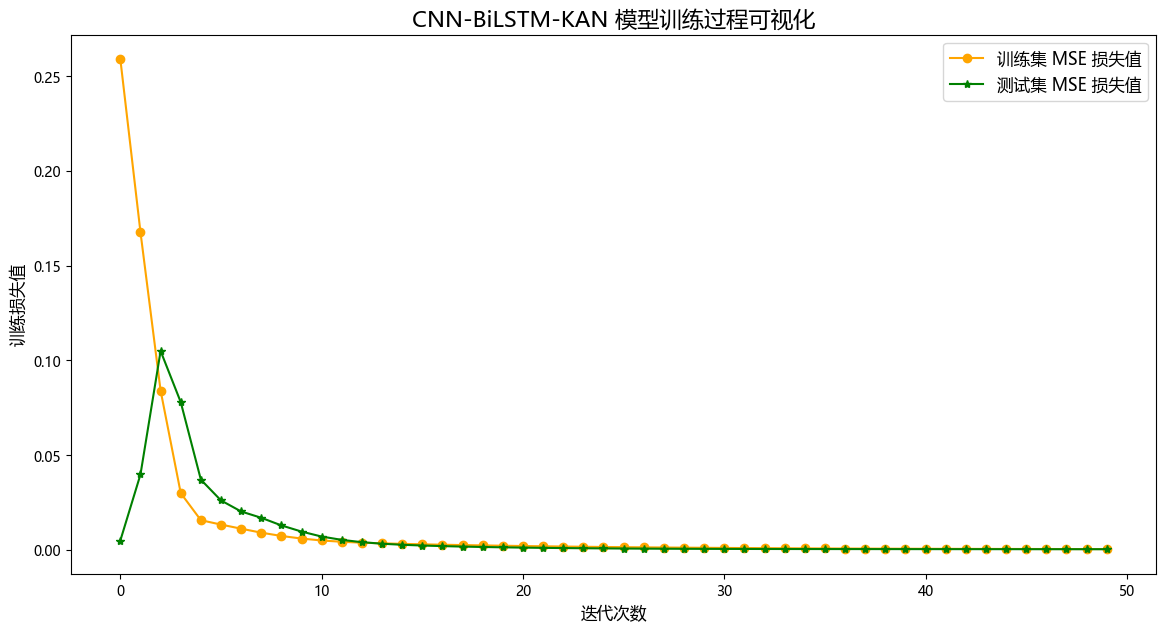

min_MSE: 0.00019744134624488652


In [68]:
# 训练模型
import time
import copy
import matplotlib
import matplotlib.pyplot as plt
plt.rcParams['font.sans-serif']=['simhei'] # 添加中文字体为黑体
plt.rcParams["axes.unicode_minus"] = False
import os
os.environ["KMP_DUPLICATE_LIB_OK"] = "True"


def model_train(model, epochs, loss_function, optimizer, train_loader, test_loader, device):
    model = model.to(device)
    # 最低MSE  
    minimum_loss = 1000.
    # 最佳模型
    best_model = model

    train_loss_history  = []     # 记录在训练集上每个epoch的loss的变化情况
    test_loss_history = []       # 记录在测试集上每个epoch的loss的变化情况

    # 计算模型运行时间
    start_time = time.time()

    for epoch in range(epochs):
        print(f'Epoch {epoch+1}/{epochs}')
        # === 训练阶段 ===
        model.train()
        train_loss_epoch = 0.0    #保存当前epoch的loss和

        for seq, labels in train_loader: 
            seq, labels = seq.to(device), labels.to(device)
            # 每次更新参数前都梯度归零和初始化
            optimizer.zero_grad()
            # 前向传播
            y_pred = model(seq)
            # 损失计算
            loss = loss_function(y_pred, labels)
            # 统计指标
            train_loss_epoch += loss.item() * seq.size(0)
            # 反向传播和参数更新
            loss.backward()
            optimizer.step()
        #     break
        # break
        # 计算总平均损失
        train_loss = train_loss_epoch / len(train_loader.dataset)
        train_loss_history.append(train_loss)

        # === 验证阶段 ===
        # 将模型设置为评估模式
        model.eval()
        test_loss_epoch = 0.0    #保存当前epoch的loss和

        with torch.no_grad():
            for data, label in test_loader:
                data, label = data.to(device), label.to(device)
                pre = model(data)
                # 计算损失
                test_loss = loss_function(pre, label)
                # 统计指标
                test_loss_epoch += loss.item() * data.size(0)
            
        # 计算总损失
        test_loss = test_loss_epoch / len(test_loader.dataset) 
        test_loss_history.append(test_loss)

        # 如果当前模型的准确率优于之前的最佳准确率，则更新最佳模型
        #保存当前最优模型参数
        if test_loss < minimum_loss:
            minimum_loss = test_loss
            # 深拷贝模型参数
            best_model = copy.deepcopy(model)# 更新最佳模型的参数

        # 打印日志
        print(f"Train Loss: {train_loss:.4f} | "
              f"Test Loss: {test_loss:.4f}")
        print('-' * 10)

    # 保存最好的参数
    torch.save(best_model, 'best_model_cnn_bilstm_kan.pt')
    print(f'\nDuration: {time.time() - start_time:.0f} seconds')
    
    # 可视化
    # 创建训练损失图
    plt.figure(figsize=(14, 7), dpi=100)  # dpi 越大  图片分辨率越高，写论文的话 一般建议300以上设置
    plt.plot(range(epochs), train_loss_history,label = '训练集 MSE 损失值', marker='o', color='orange')
    plt.plot(range(epochs), test_loss_history,label = '测试集 MSE 损失值', marker='*', color='green')
    plt.xlabel('迭代次数', fontsize=12)
    plt.ylabel('训练损失值', fontsize=12)
    plt.xticks(fontsize=10)
    plt.yticks(fontsize=10)
    plt.legend(fontsize=12)
    plt.title('CNN-BiLSTM-KAN 模型训练过程可视化', fontsize=16)
    plt.show()   #显示 lable 
    print(f'min_MSE: {minimum_loss}')

#  模型训练
epochs = 50
model_train(model, epochs, loss_function, optimizer, train_loader, test_loader, device)

In [69]:
# 模型预测
# 模型 测试集 验证  
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = torch.load('best_model_cnn_bilstm_kan.pt', weights_only=False)
model = model.to(device)

# 原始特征
test_original_features = []
# 原始数据
original_test = []
# 预测数据
pre_test = []

model.eval()  # 将模型设置为评估模式
with torch.no_grad():
        for data, label in test_loader:
            test_original_features += data.tolist()  # 提取特征
            
            # 原始
            original = label.tolist()
            original_test += original

            # 预测
            data, label = data.to(device), label.to(device)
            test_pred = model(data)  # 对测试集进行预测
            # 预测
            test_pred = test_pred.tolist()
            pre_test += test_pred

### 模型评估

In [70]:
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# 模型分数
score = r2_score(original_test, pre_test)
print('测试集上 模型分数-R^2:',score)

print('*'*50)
# 训练集上的预测误差
train_mse = mean_squared_error(original_test, pre_test)
train_rmse = np.sqrt(train_mse)
train_mae = mean_absolute_error(original_test, pre_test)
print('测试数据集上的均方误差-MSE: ',train_mse)
print('测试数据集上的均方根误差-RMSE: ',train_rmse)
print('测试数据集上的平均绝对误差-MAE: ',train_mae)

测试集上 模型分数-R^2: 0.8899488636256347
**************************************************
测试数据集上的均方误差-MSE:  0.00837594774537943
测试数据集上的均方根误差-RMSE:  0.09152020402828782
测试数据集上的平均绝对误差-MAE:  0.08011290413444701


### 预测可视化


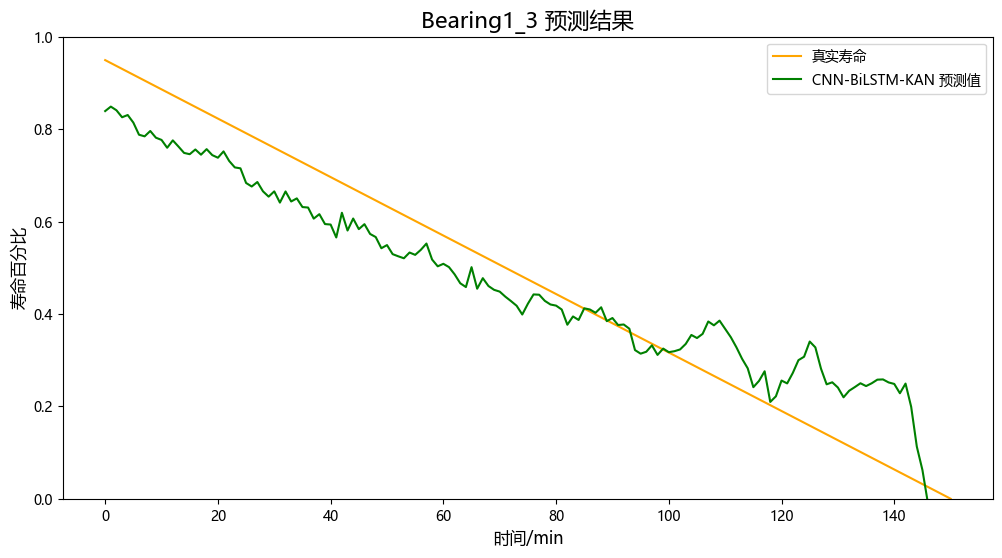

In [71]:
import matplotlib.pyplot as plt
plt.rcParams['font.sans-serif']=['simhei'] # 添加中文字体为黑体
plt.rcParams["axes.unicode_minus"] = False

# 可视化结果
plt.figure(figsize=(12, 6), dpi=100)
plt.plot(original_test, label='真实寿命',color='orange')  # 真实值
plt.plot(pre_test, label='CNN-BiLSTM-KAN 预测值',color='green')  # 预测值

# plt.plot([-1,170],[2.0*0.7,2.0*0.7],c='black',lw=1,ls='--')  # 临界点直线  可自己调整位置
# 设置y轴范围为0到1
plt.ylim(0, 1)

plt.xlabel('时间/min', fontsize=12)
plt.ylabel('寿命百分比', fontsize=12)
plt.title('Bearing1_3 预测结果', fontsize=16)
plt.legend()
plt.show()

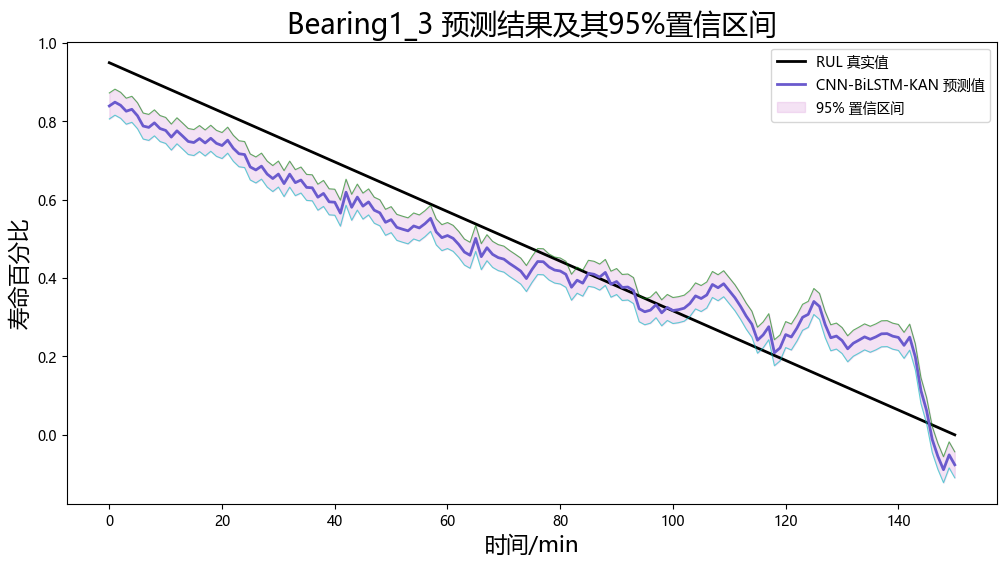

In [72]:
import os 
import matplotlib
import matplotlib.pyplot as plt
matplotlib.rc("font", family='Microsoft YaHei')
from scipy.stats import t

test_origin_data = np.array(original_test).reshape(-1, )
test_pre_data =  np.array(pre_test).reshape(-1, )

# 绘制图形
plt.figure(figsize=(12, 6), dpi=100)


# 计算置信区间
mean = np.mean(test_pre_data)
std_dev = np.std(test_pre_data)
conf_interval = 1.96 * (std_dev / np.sqrt(len(test_pre_data)))  # 95%置信区间
# 计算置信区间上下限
lower_bound = test_pre_data - conf_interval
upper_bound = test_pre_data + conf_interval


x = [t for t in range(len(test_origin_data))]

# 绘制图形
plt.plot(x, test_origin_data, 'black', linewidth=2, label='RUL 真实值')
plt.plot(x, test_pre_data, 'slateblue', linewidth=2, label='CNN-BiLSTM-KAN 预测值')

# 绘制置信区间
# ax.axvline(x=len(data)-len(pre_l), ymin=0,color='black',ls=':')
# ax.fill_between(x, pre_l - conf_interval, pre_l + conf_interval, color='red', alpha=0.25,label='95% Confidence Interval')
plt.fill_between(x, lower_bound, upper_bound, color='plum', alpha=0.3, label='95% 置信区间')
# 绘制上下限线条
plt.plot(x, lower_bound, color='c', linestyle='-', linewidth=0.8,  alpha=0.6)
plt.plot(x, upper_bound, color='green', linestyle='-', linewidth=0.8,  alpha=0.6)

# 添加标签和图例
plt.xlabel('时间/min', fontsize=16)
plt.ylabel('寿命百分比', fontsize=16)
plt.title('Bearing1_3 预测结果及其95%置信区间', fontsize=20)
plt.legend()

# 显示图形
plt.show()

# SHAP 可视化

In [73]:
# 1. 使用 torch.tensor 函数将二维列表转换为 PyTorch 张量
tensor_data = torch.tensor(test_original_features) 
tensor_data.size()

torch.Size([151, 7, 13])

In [74]:
import shap
tensor_data = tensor_data.to(device)
# 假设 model 是你的 PyTorch 模型，tensor_data 是你的输入数据
explainer = shap.DeepExplainer(model, tensor_data)

# 在解释之前将模型设置为训练模式
model.train()
# 计算 SHAP 值
shap_values = explainer.shap_values(tensor_data, check_additivity=False)  # (301, 12, 8)

# 切换回评估模式
model.eval()
data_numpy = tensor_data.cpu().detach().numpy()  # 确保 data 是 NumPy 数组，并移动到 CPU

unrecognized nn.Module: SiLU
unrecognized nn.Module: LSTM


In [75]:
shap_values = np.array(shap_values)
shap_values.shape

(151, 7, 13)

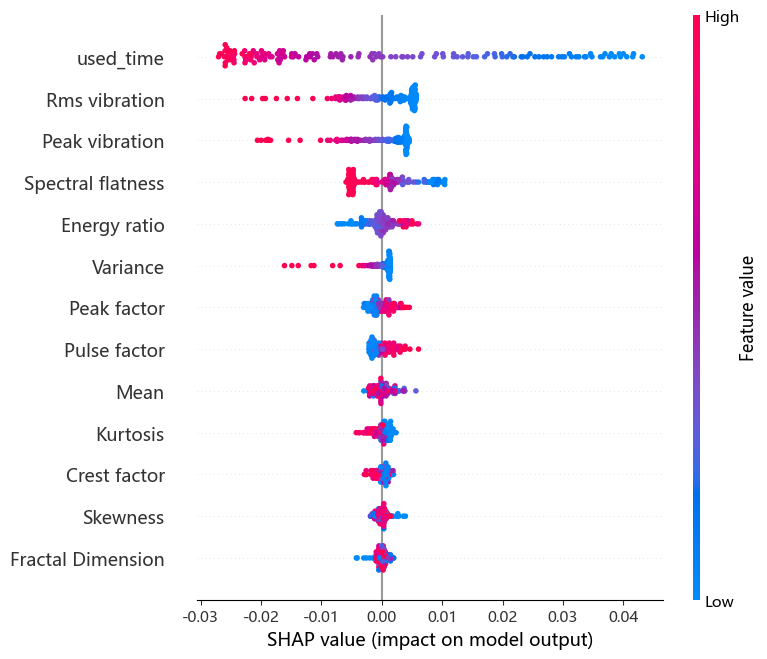

In [76]:
# 需要把每个样本的7x13特征展开成一维数组，方便绘图
# reshape成 (样本数, 特征数)，这里特征数=7*13=91
# 对每个窗口序列进行平均计算，axis=1
shap_avg = np.mean(shap_values, axis=1)  # 结果形状 (301, 13)
# 原始数据也做同样处理
data_avg = np.mean(data_numpy, axis=1)  # (301, 13)

# 对应的13个特征名称，传入 feature_names
feature_names = ['Kurtosis', 'Fractal Dimension', 'Peak factor', 'Pulse factor',
       'Crest factor', 'Energy ratio', 'Spectral flatness', 'Mean', 'Variance',
       'Skewness', 'Peak vibration', 'Rms vibration', 'used_time']
# 调用summary_plot 可视化 SHAP 值
shap.summary_plot(shap_avg, data_avg, feature_names=feature_names)

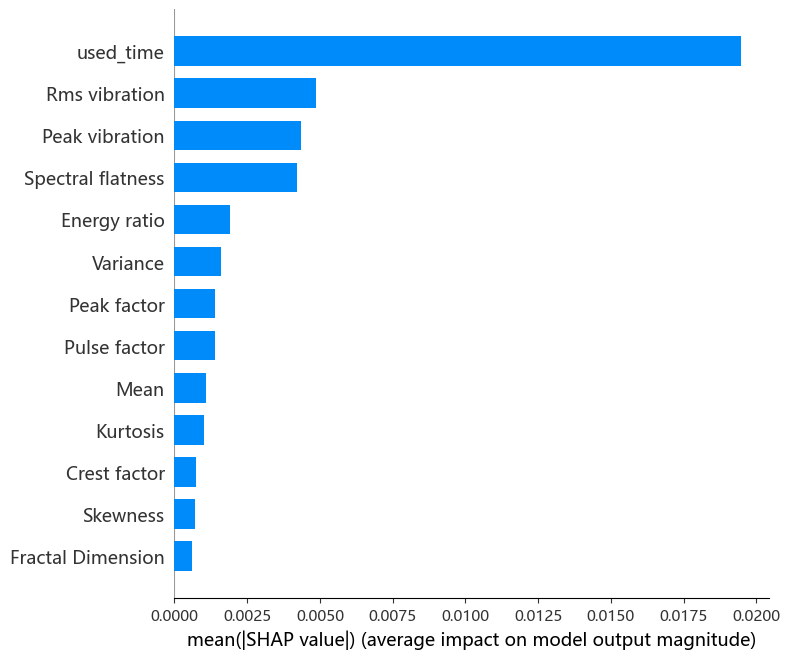

In [77]:
shap.summary_plot(shap_avg, data_avg, 
                  plot_type="bar", feature_names=feature_names)